## Simple EDA

This time, it's a project with so many features.

For a fun project, I lightly conducted EDA.

- No missing value.
- There are 100 numerical continuous features.
- The target variable loss ranges from 0 to 42 for a total of 43 discrete values. However, this is a regression problem and it is OK to submit as decimal values.

## Load Data & Library

Let's load a library for basic data.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# matplotlib setting
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')

In [ ]:
print(f'Train Shape :  {train.shape}')
print(f'Test Shape :  {test.shape}')

Train Shape :  (250000, 102)
Test Shape :  (150000, 101)


In [ ]:
target = train['loss']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [ ]:
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,1.09101,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,1.28138,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,1.24210,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,1.09130,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,1.10151,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 101 entries, f0 to loss
dtypes: float64(95), int64(6)
memory usage: 192.6 MB


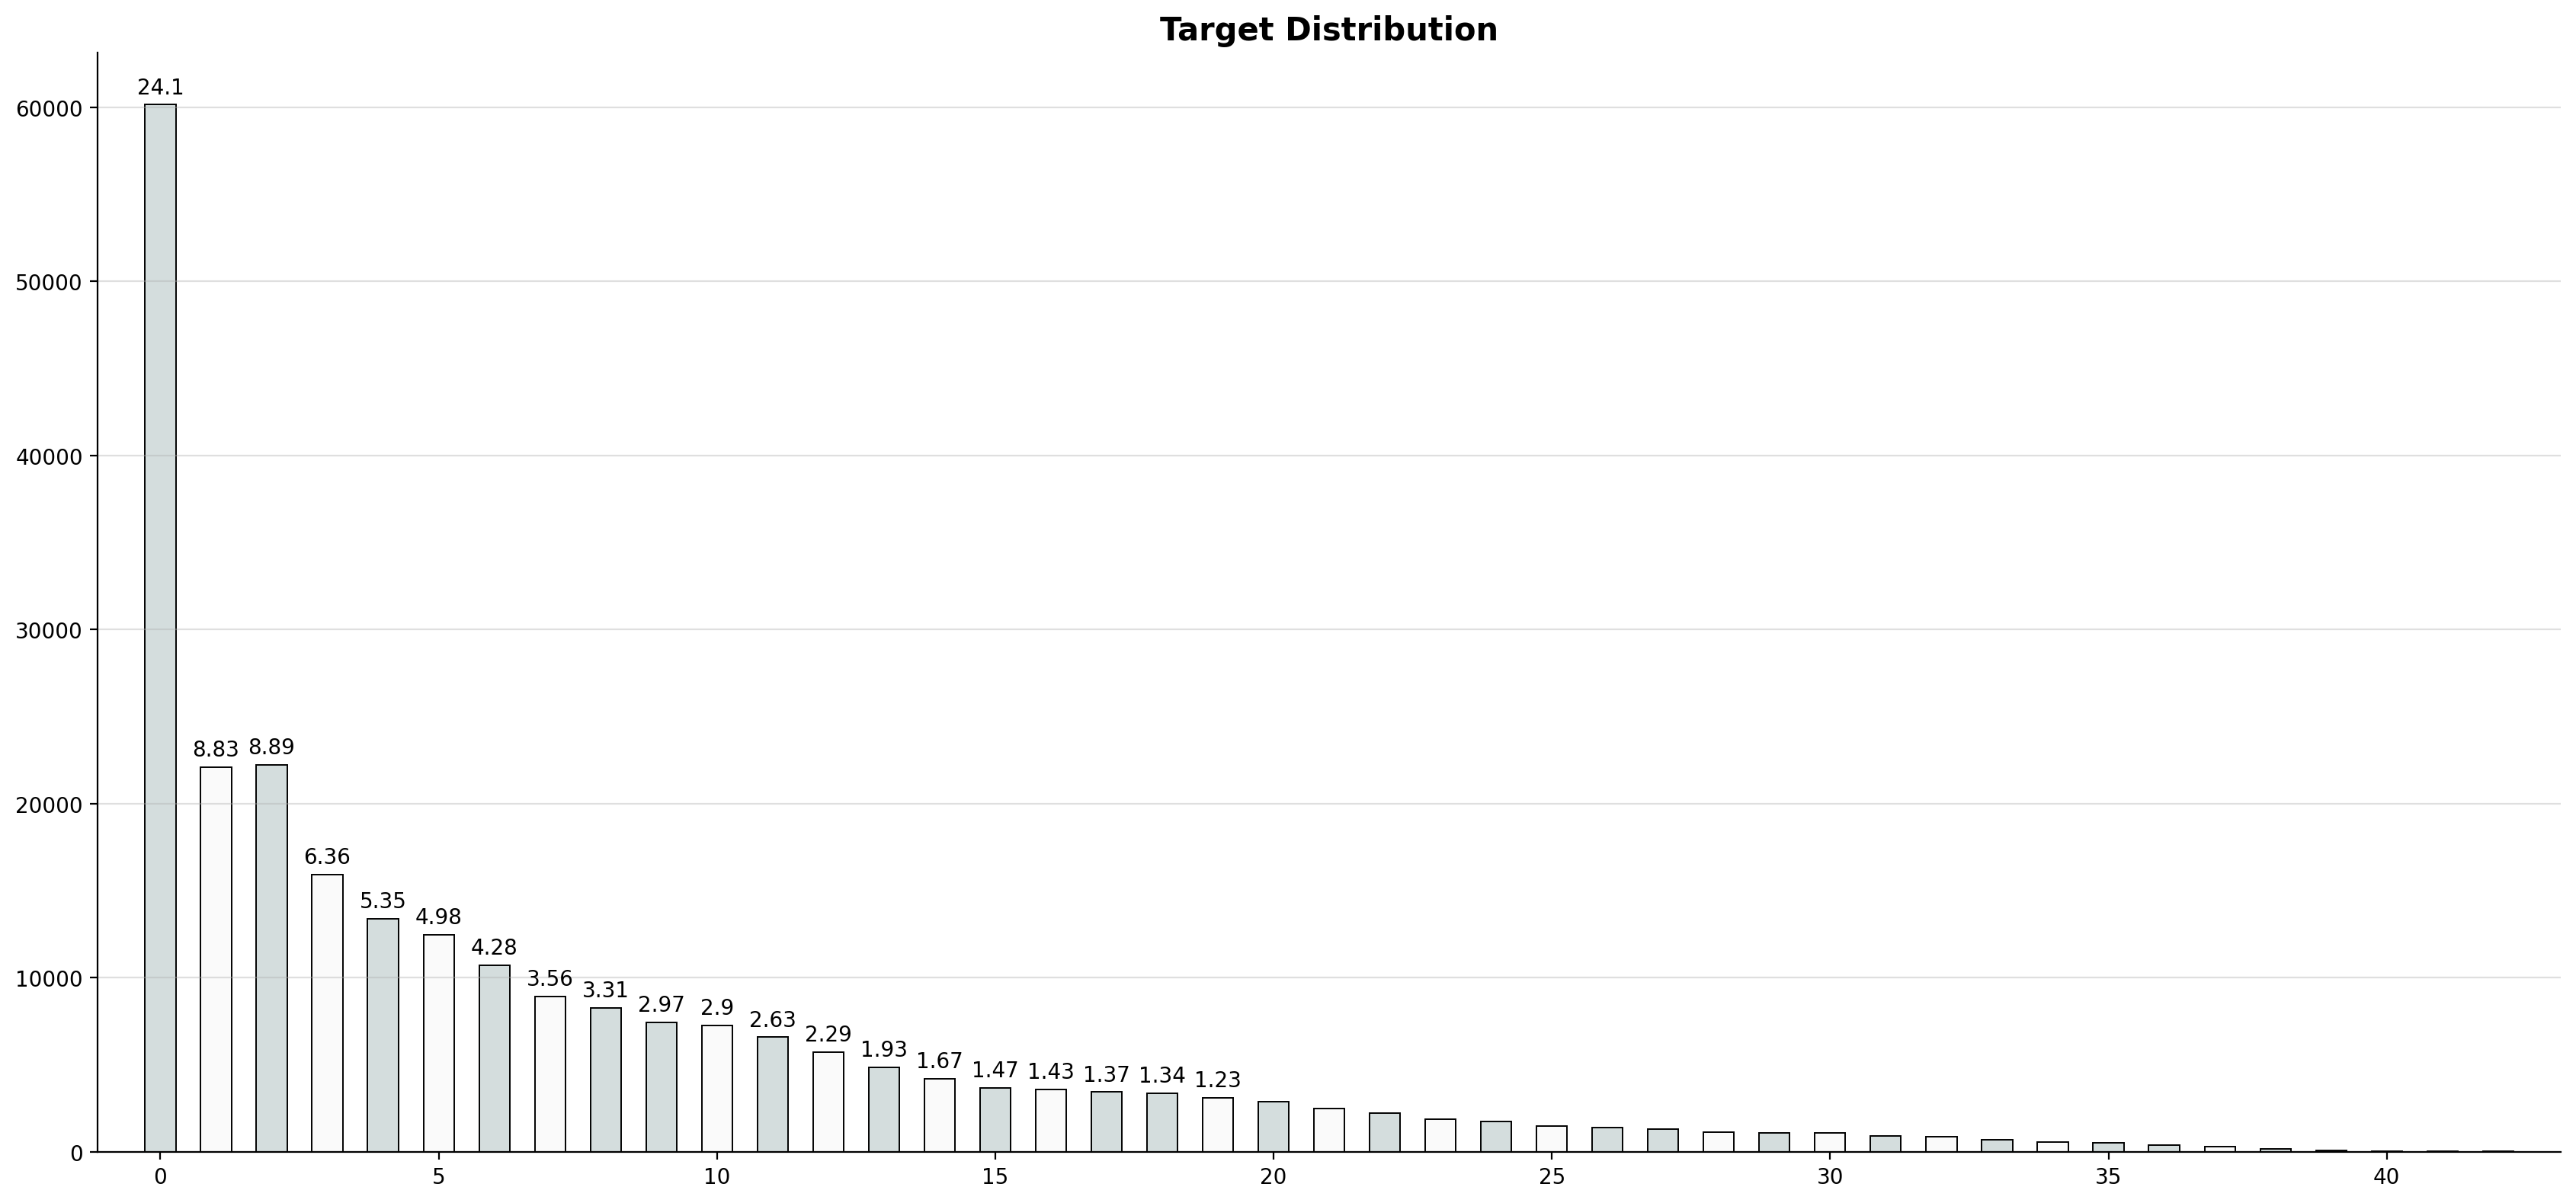

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17, 8))

target_cnt = train['loss'].value_counts().sort_index()

ax.bar(target_cnt.index, target_cnt, color=['#d4dddd' if i%2==0 else '#fafafa' for i in range(9)],
       width=0.55,
       edgecolor='black',
       linewidth=0.7)

ax.margins(0.02, 0.05)

for i in range(20):
    ax.annotate(f'{target_cnt[i]/len(train)*100:.3}', xy=(i, target_cnt[i]+1000),
                   va='center', ha='center',
               )

ax.set_title('Target Distribution', weight='bold', fontsize=15)
ax.grid(axis='y', linestyle='-', alpha=0.4)

fig.tight_layout()
plt.show()

- There are a total of 43 discrete losses.
- The top 12 distributions account for 80% of the total.
- All except the order of 2 and 1 are in increasing order.

In [ ]:
target_cnt_df = pd.DataFrame(target_cnt)
target_cnt_df['ratio(%)'] = target_cnt_df/target_cnt.sum()*100
target_cnt_df.sort_values('ratio(%)', ascending=False, inplace=True)
target_cnt_df['cummulated_sum(%)'] = target_cnt_df['ratio(%)'].cumsum()
target_cnt_df.style.bar(subset=['cummulated_sum(%)'], color='#205ff2')

,loss,ratio(%),cummulated_sum(%)
0,60144,24.057600,24.057600
2,22225,8.890000,32.947600
1,22069,8.827600,41.775200
3,15902,6.360800,48.136000
4,13371,5.348400,53.484400
5,12458,4.983200,58.467600
6,10697,4.278800,62.746400
7,8894,3.557600,66.304000
8,8264,3.305600,69.609600
9,7435,2.974000,72.583600


## Statistics Check

The scale of this data is really diverse.

It doesn't matter if you use a tree-based model, but scaling is essential by default.

In [ ]:
train.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
f0,250000.000000,0.511213,0.307884,-0.069273,0.251287,0.514962,0.777323,1.072070
f1,250000.000000,51.378476,42.396636,-17.000000,18.000000,41.000000,75.000000,273.000000
f2,250000.000000,0.107155,1.322200,-7.895580,-0.611172,0.253815,0.759249,9.768590
f3,250000.000000,0.050010,0.792368,-1.475560,-0.719418,0.004099,0.765456,1.680190
f4,250000.000000,3595.133426,6072.401061,-7589.280000,163.864750,943.000500,4115.355000,37847.500000
f5,250000.000000,8.205953,5.475723,-3.291050,4.110127,7.472445,11.030950,35.078000
f6,250000.000000,164.508753,183.335563,-40.967200,27.894900,91.005250,240.843750,947.143000
f7,250000.000000,0.375533,0.813597,-4.143080,-0.026245,0.619862,0.933855,4.010380
f8,250000.000000,16.669745,99.758709,-502.813000,-17.392025,8.714945,55.407625,465.956000
f9,250000.000000,1.190382,0.099700,0.934037,1.132640,1.170370,1.218880,1.712450


- There is data without decimal point.
- The range of data is diverse.

## Discrete Features

Some data are found to have no decimal point.

In [ ]:
discrete_features = []

for col in train.columns:
    if np.array_equal(train[col].values, train[col].values.astype(int)):
        discrete_features.append(col)

print(f'Total {len(discrete_features)} : ')
print(discrete_features)

Total 7 : 
['f1', 'f16', 'f27', 'f55', 'f60', 'f86', 'loss']


A total of 6 features have no decimal point.

- `f1`
- `f16`
- `f27`
- `f55`
- `f60`
- `f86`


In [ ]:
for dcol in discrete_features:
    print(f'{dcol} unique value : {train[dcol].nunique()}')

f1 unique value : 289
f16 unique value : 247476
f27 unique value : 37471
f55 unique value : 4726
f60 unique value : 212504
f86 unique value : 329
loss unique value : 43


While the total number of data is 250000, most of the data in `f16` and `f60` are confirmed as continuous with different values, but the remaining `f1`, `f27`, `f55`, and `f86` look relatively categorical.

Looking at f1 and f86 with a small number of unique values:
For the relationship with the loss, we averaged after groupby.

In [ ]:
f1_loss = train.groupby(['f1'])['loss'].mean().sort_values()
print((f1_loss==0).sum())

5


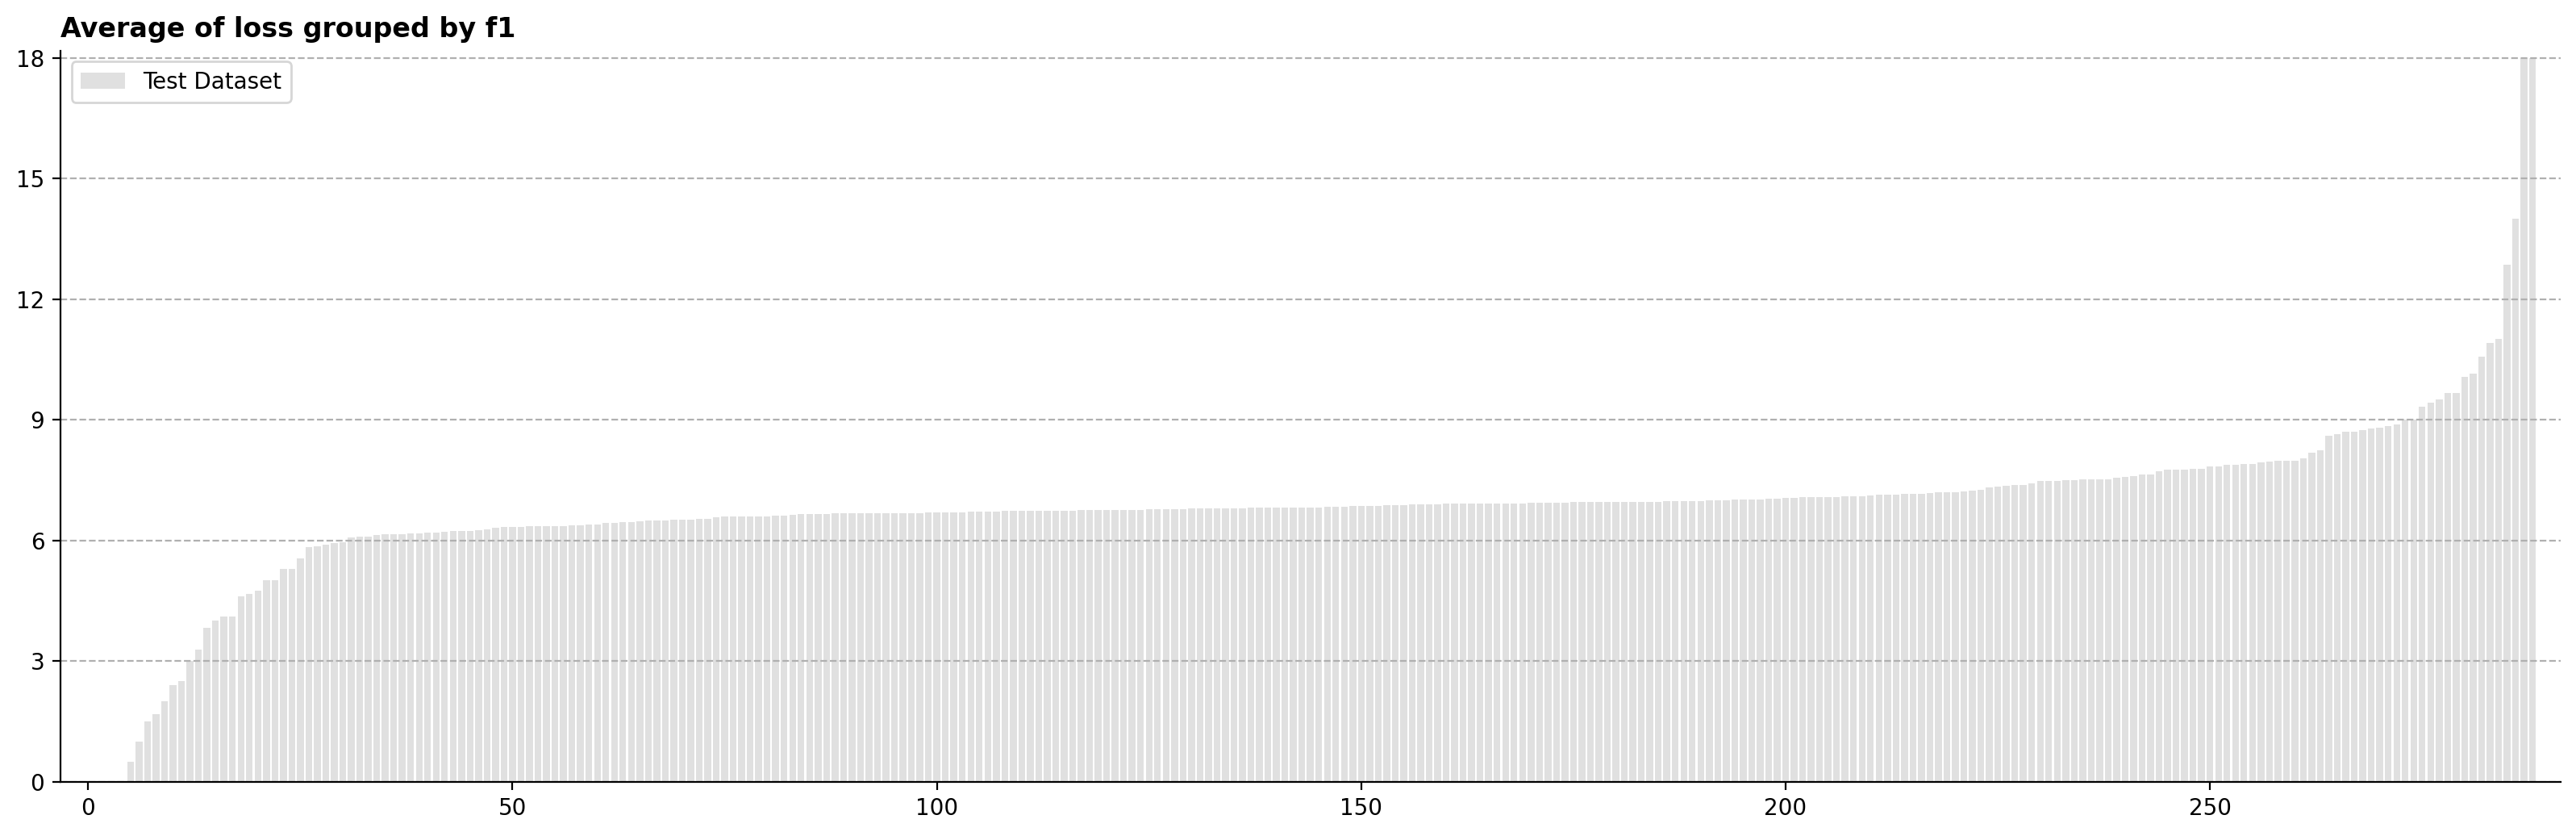

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.bar(range(len(f1_loss)), f1_loss, alpha=0.7, color='lightgray', label='Test Dataset')
ax.set_yticks(range(0, 20, 3))
ax.margins(0.01)
ax.grid(axis='y', linestyle='--', zorder=5)
ax.set_title('Average of loss grouped by f1', loc='left', fontweight='bold')
ax.legend()
plt.show()

- Depending on the value of f1, we can check the imbalance of loss.
- In 5 cases, we confirmed that the loss is all 0.

In [ ]:
f86_loss = train.groupby(['f86'])['loss'].mean().sort_values()
print((f86_loss==0).sum())

2


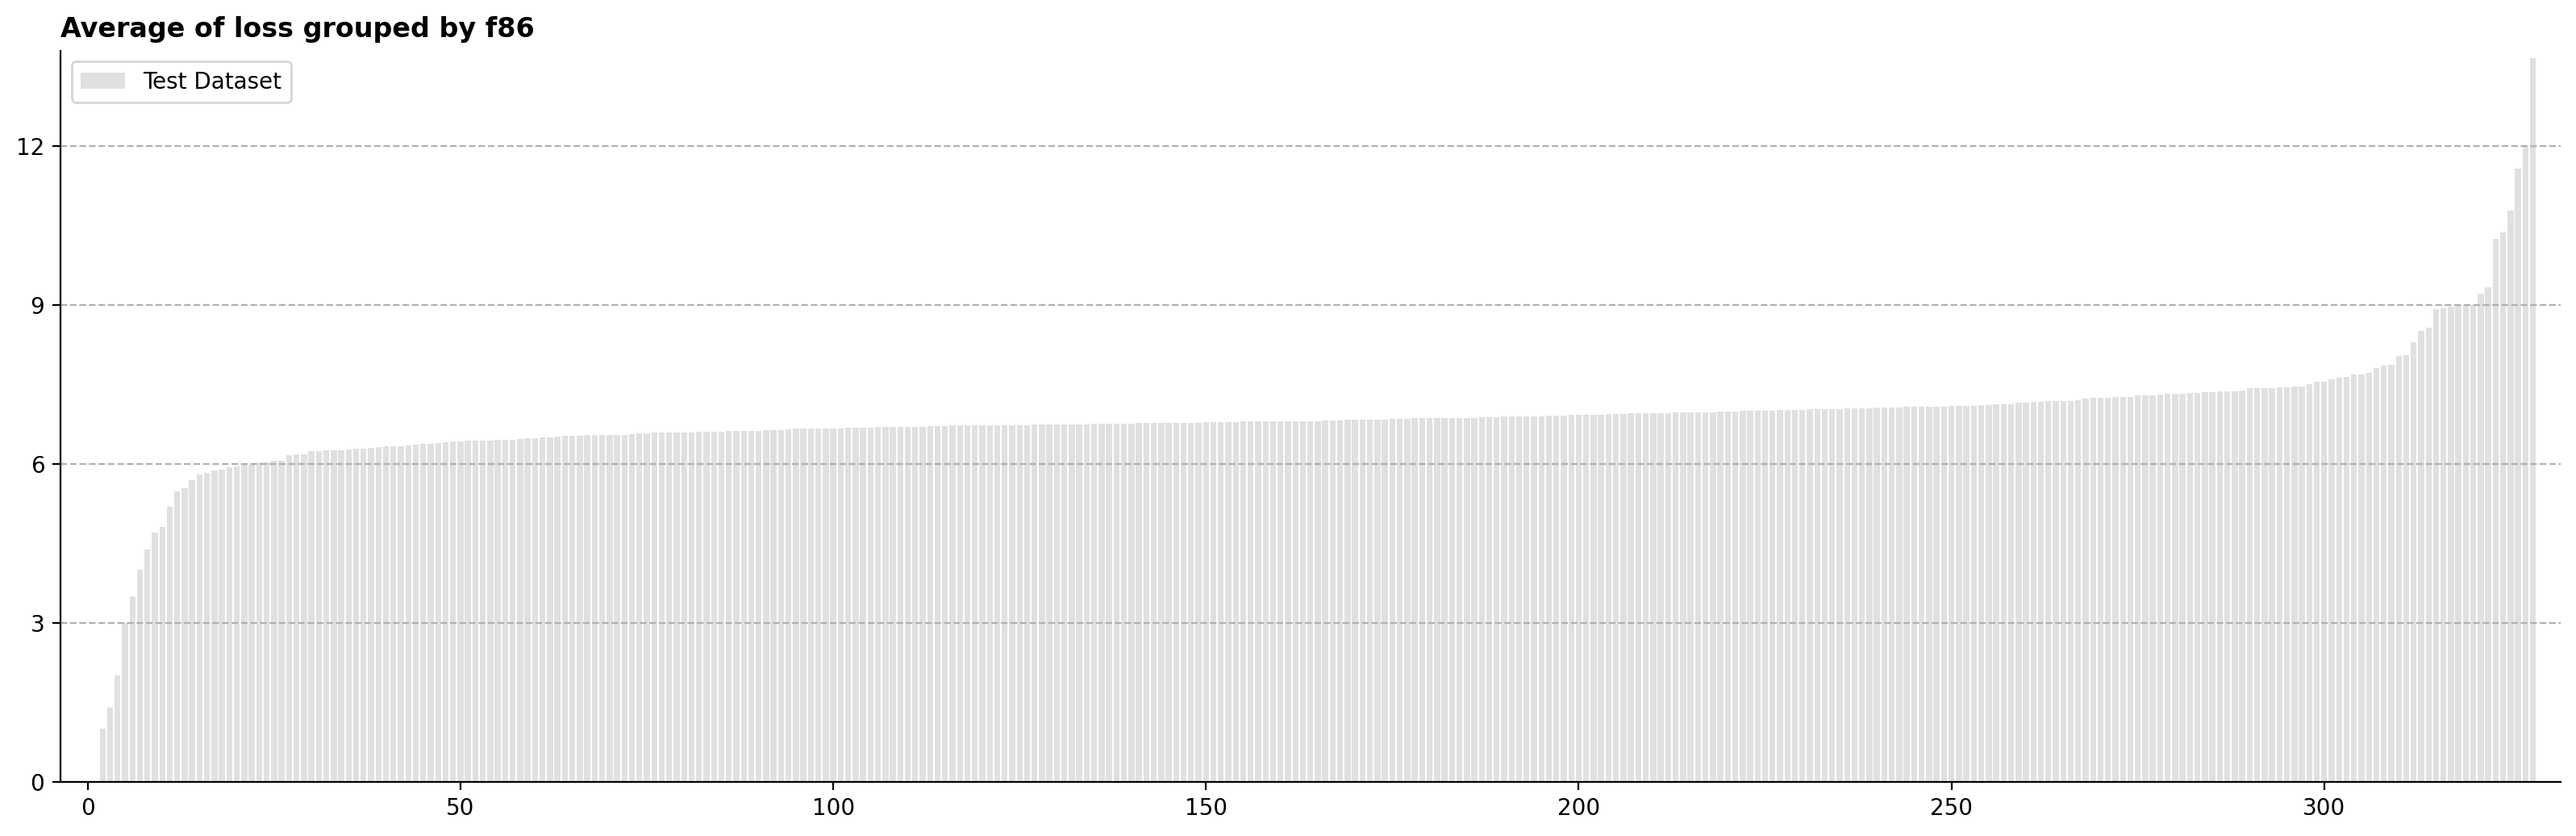

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.bar(range(len(f86_loss)), f86_loss, alpha=0.7, color='lightgray', label='Test Dataset')
ax.set_yticks(range(0, 20, 3))
ax.margins(0.01)
ax.grid(axis='y', linestyle='--', zorder=5)
ax.set_title('Average of loss grouped by f86', loc='left', fontweight='bold')
ax.legend()
plt.show()

- I noticed that there is an imbalance, though not as much as f1.

## Scaling

Except for tree-based models, you need to scale the data.

Before visualization, we will adjust the line and proceed with the visualization.

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
features = [f'f{i}' for i in range(100)]
train[features] = ss.fit_transform(train[features])
test[features] = ss.transform(test[features])

## Target & Feature Relation

As the value of targets increases, the mean moves away from zero.

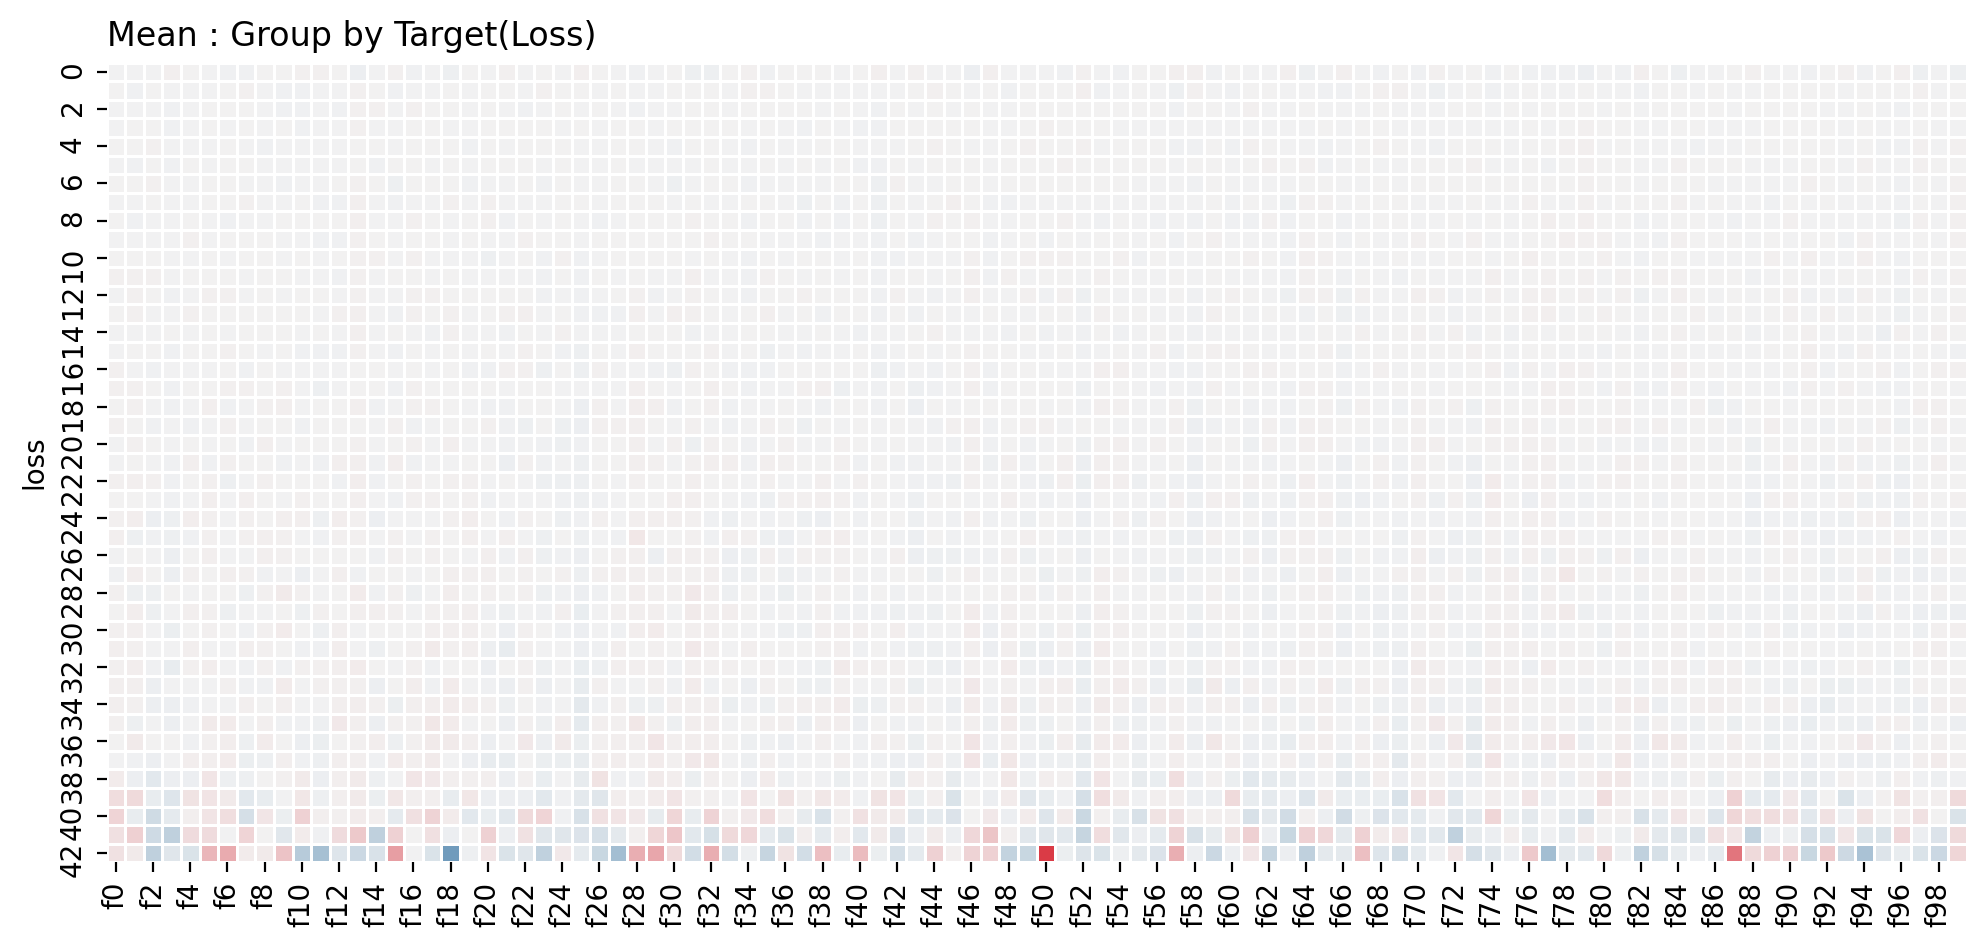

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
sns.heatmap(train.groupby('loss').mean().sort_index(),
            square=True, center=0, linewidth=1,
            cmap=sns.diverging_palette(240, 10, as_cmap=True),
            cbar=False,
           )

ax.set_title('Mean : Group by Target(Loss)',loc='left')
plt.show()

Let's take a look by adjusting the range of expression.

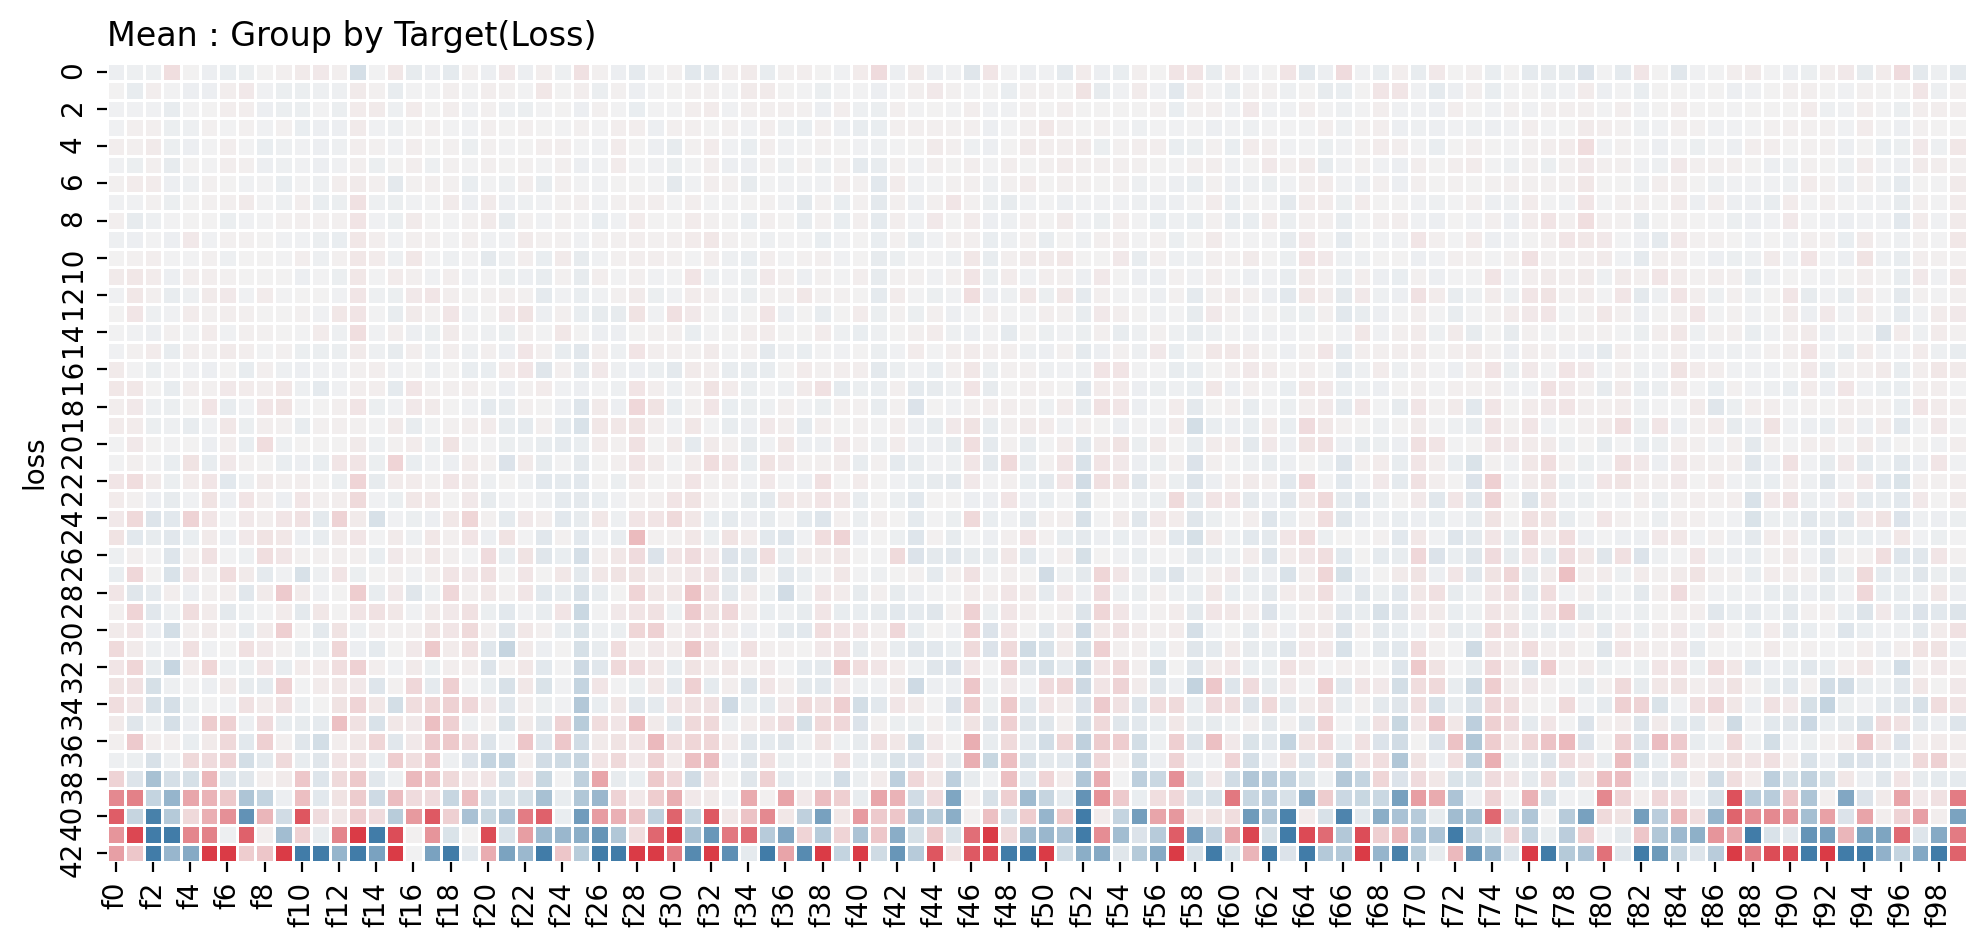

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
sns.heatmap(train.groupby('loss').mean().sort_index(),
            square=True, vmin=-0.5, vmax=0.5, center=0, linewidth=1,
            cmap=sns.diverging_palette(240, 10, as_cmap=True),
            cbar=False,
           )

ax.set_title('Mean : Group by Target(Loss)',loc='left')
plt.show()

There seems to be an increasing trend and a decreasing trend.

## Feature Distribution

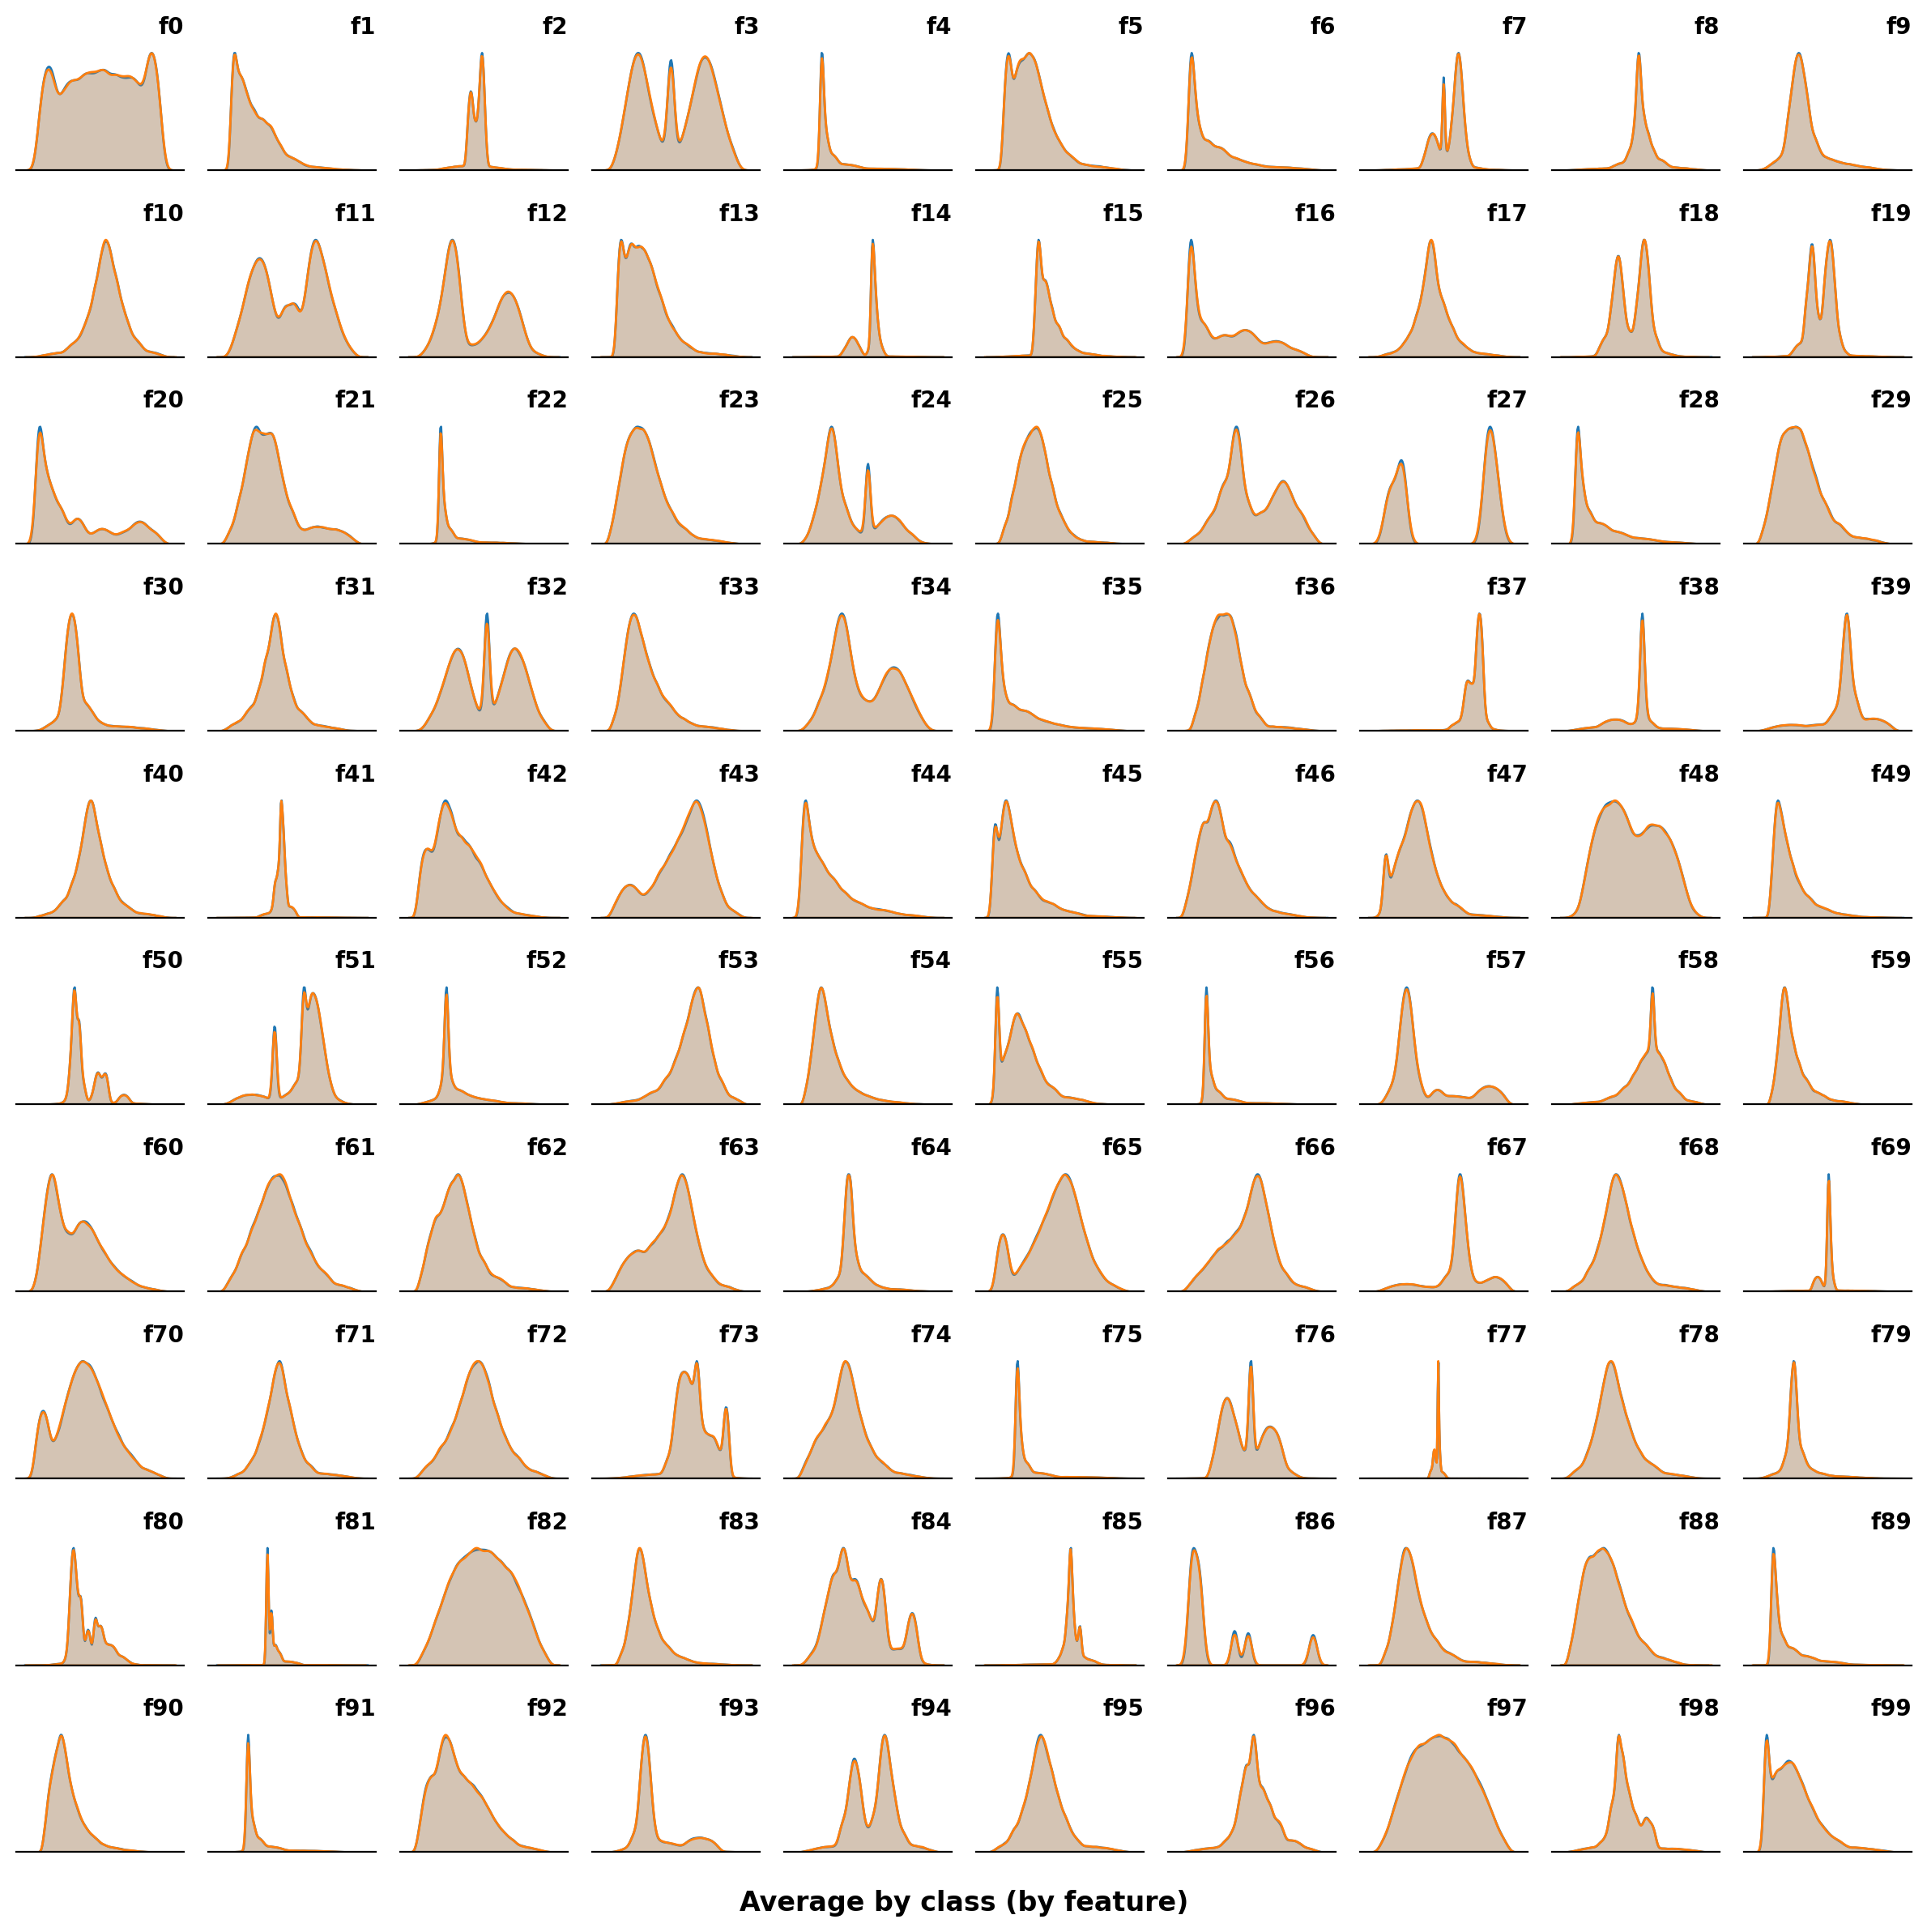

In [ ]:
fig, axes = plt.subplots(10,10,figsize=(12, 12))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.kdeplot(data=train, x=f'f{idx}',
                fill=True,
                ax=ax)
    sns.kdeplot(data=test, x=f'f{idx}',
                fill=True,
                ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    ax.set_title(f'f{idx}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Average by class (by feature)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()



It's scaled up, but it's a pretty interesting aspect of the data.

It is safe to assume that the distributions of train and test are almost the same.

## Correlation

It can be seen that most of the correlations are close to zero.

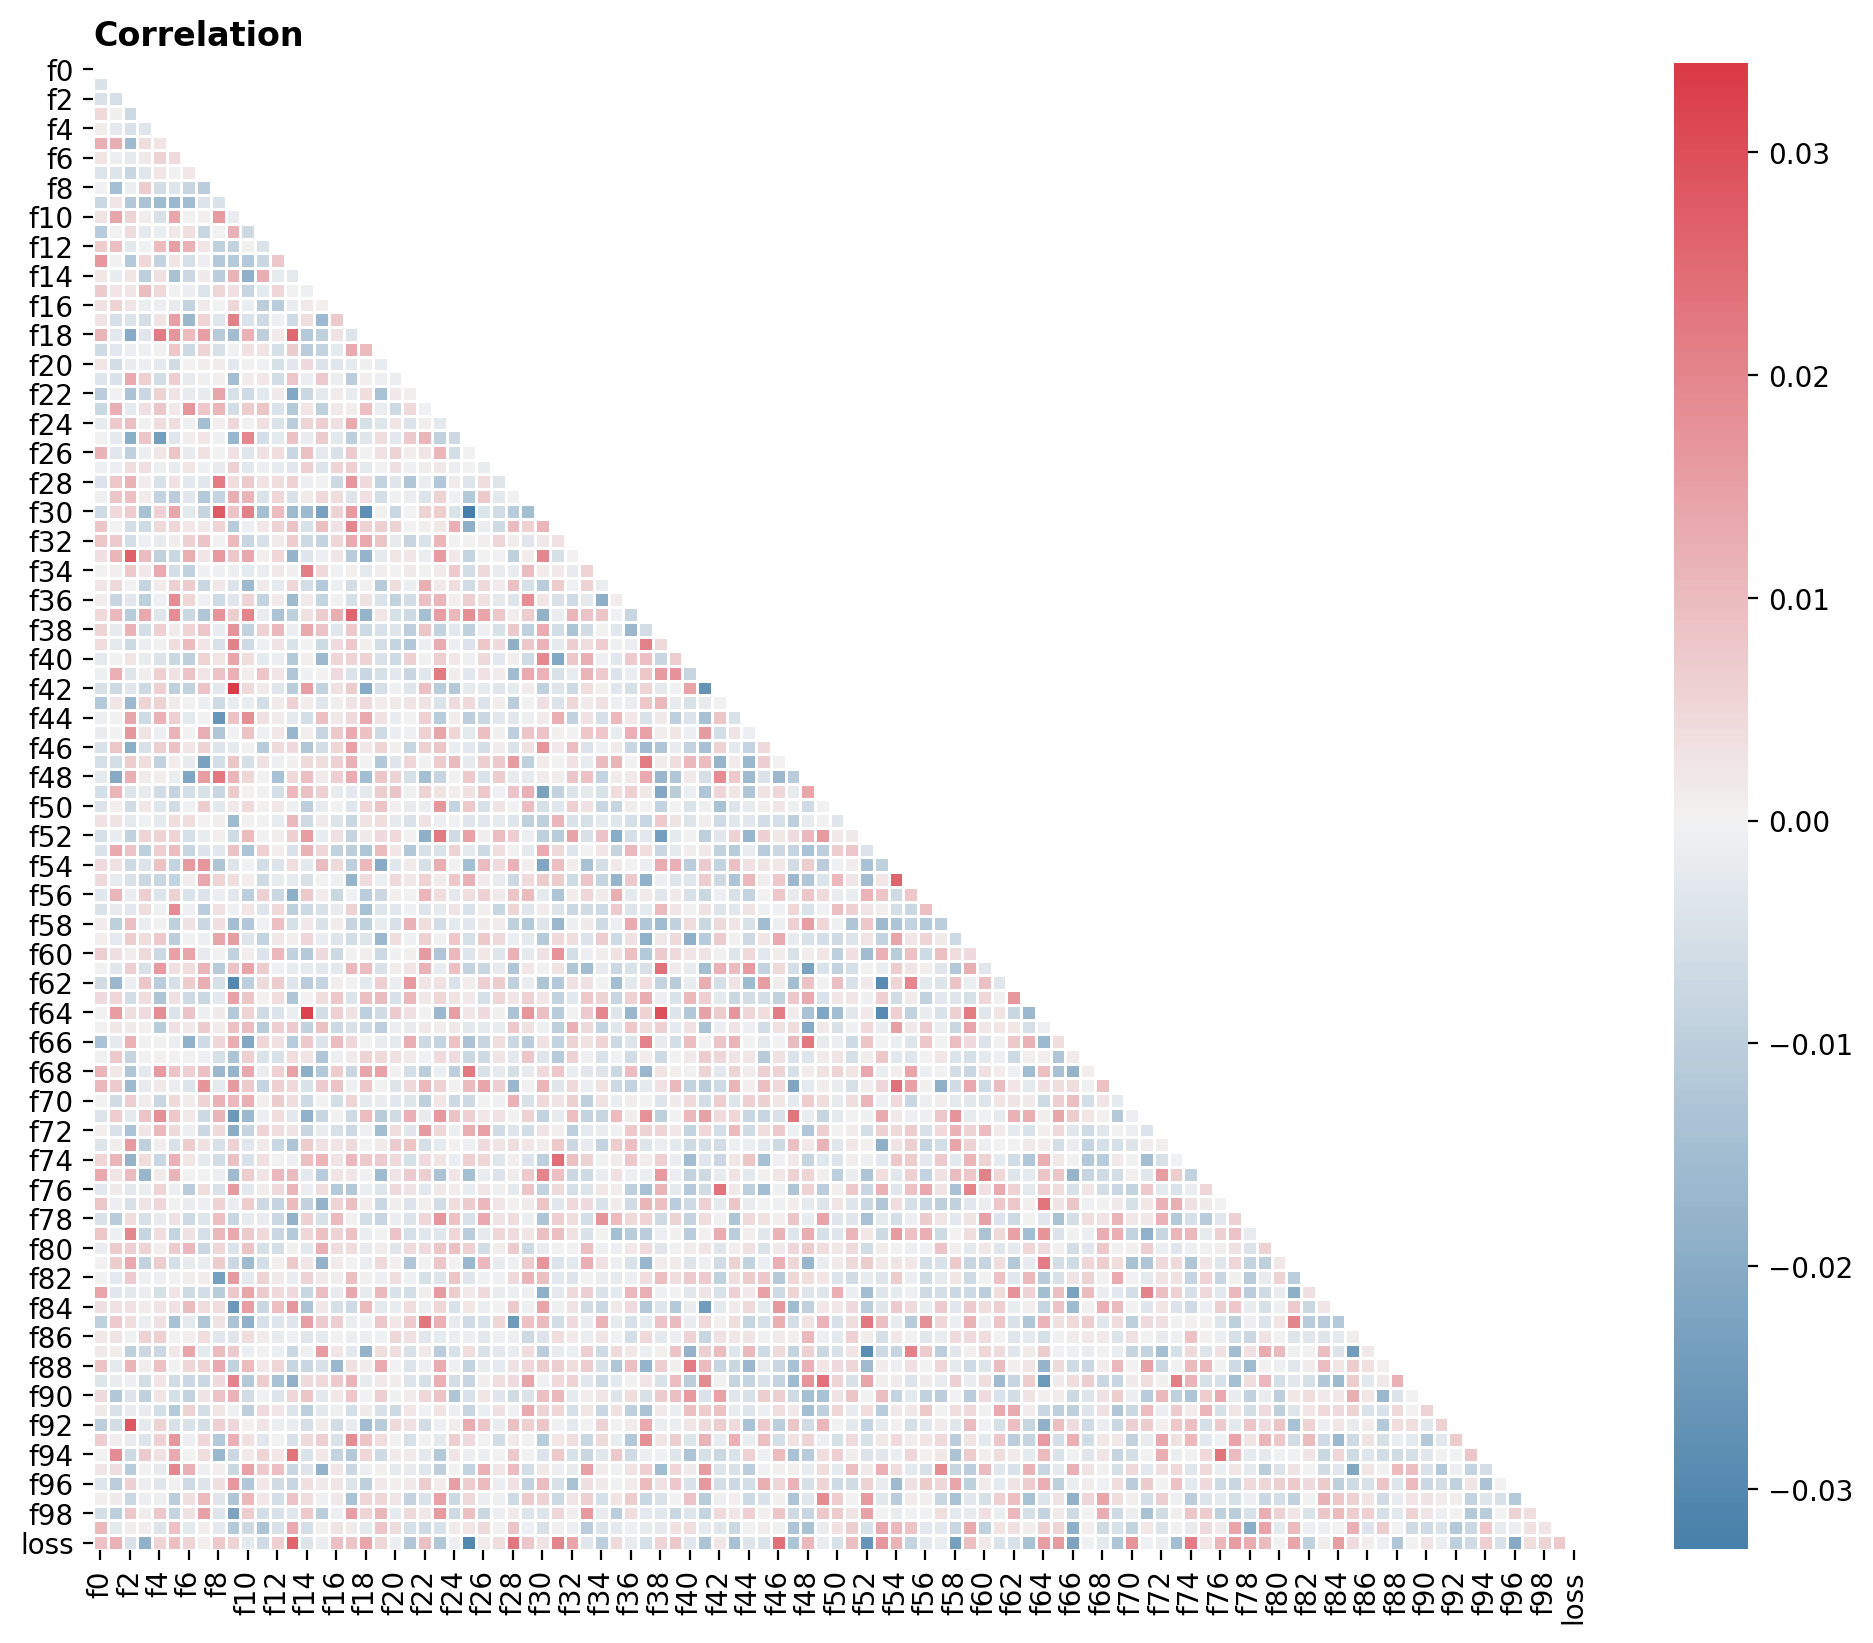

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12 , 12))

corr = train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, ax=ax,
        square=True, center=0, linewidth=1,
        cmap=sns.diverging_palette(240, 10, as_cmap=True),
        cbar_kws={"shrink": .82},
        mask=mask
       )

ax.set_title(f'Correlation', loc='left', fontweight='bold')

plt.show()